In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
from datasets import load_dataset, load_metric

model_checkpoint = "Helsinki-NLP/opus-mt-de-en/"
raw_datasets = load_dataset('wmt16/de-en')
metric = load_metric("sacrebleu")

/tmp/ipykernel_1726/3851827311.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")
/root/miniconda3/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MarianConfig

model_config = MarianConfig.from_pretrained(model_checkpoint)
# 修改配置
model_config.output_hidden_states = True
model_config.output_attentions = True

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

/root/miniconda3/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
import datasets

# 取出各个子集的一部分数据
train_subset = raw_datasets["train"].select(range(1000000))
validation_subset = raw_datasets["validation"]
test_subset = raw_datasets["test"]

# 将这些子集组合成一个新的 DatasetDict
subset_datasets = {"train": train_subset, "validation": validation_subset, "test": test_subset}
subset_dataset_dict = datasets.DatasetDict(subset_datasets)

In [5]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import numpy as np

batch_size = 16
max_input_length = 128
max_target_length = 128
source_lang = "de"
target_lang = "en"

def preprocess_function(examples):
    inputs = [ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    # model_inputs["labels_attention_mask"] = labels["attention_mask"]
    return model_inputs

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    print('enter compute_metrics')
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    print('out compute_metrics')
    return result

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
# tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
tokenized_datasets = subset_dataset_dict.map(preprocess_function, batched=True)

In [6]:
import torch.nn.init as init
import torch
from torch import nn
import transformers.models.marian.modeling_marian as marian

MarianDecoder = marian.MarianDecoder
BaseModelOutputWithPastAndCrossAttentions = marian.BaseModelOutputWithPastAndCrossAttentions
_prepare_4d_causal_attention_mask = marian._prepare_4d_causal_attention_mask
_prepare_4d_attention_mask = marian._prepare_4d_attention_mask
logger = marian.logger

Optional = marian.Optional
Union = marian.Union
Tuple = marian.Tuple
BaseModelOutput = marian.BaseModelOutput
Seq2SeqModelOutput = marian.Seq2SeqModelOutput
MarianPreTrainedModel = marian.MarianPreTrainedModel
MarianEncoder = marian.MarianEncoder
copy = marian.copy

class CustomMarianDecoder(MarianDecoder):
    def __init__(self, config: MarianConfig, embed_tokens):
        super().__init__(config, embed_tokens)

        # 添加 encoder_layers 个全连接层
        self.additional_linear_layers = nn.ModuleList([
            nn.Linear(config.hidden_size * config.encoder_layers, config.hidden_size, bias=False)
            for _ in range(config.encoder_layers)
        ])

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids) * self.embed_scale

        attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, input_shape, inputs_embeds, past_key_values_length
        )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            encoder_attention_mask = _prepare_4d_attention_mask(
                encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]
            )

        # embed positions
        positions = self.embed_positions(input_shape, past_key_values_length)

        hidden_states = inputs_embeds + positions

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                )
                use_cache = False

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None
        next_decoder_cache = () if use_cache else None

        # check if head_mask/cross_attn_head_mask has a correct number of layers specified if desired
        for attn_mask, mask_name in zip([head_mask, cross_attn_head_mask], ["head_mask", "cross_attn_head_mask"]):
            if attn_mask is not None:
                assert attn_mask.size()[0] == (len(self.layers)), (
                    f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
                    f" {head_mask.size()[0]}."
                )

        # 合并 encoder_hidden_states
        # encoder_hidden_states[5] 是 lash_hidden_state
        encoder_hidden_states_all = torch.cat(encoder_hidden_states, dim=-1)
        # print((encoder_hidden_states_all[:, :, :512] == encoder_hidden_states[5]).all())
        # print((encoder_hidden_states_all[:, :, -512:] == encoder_hidden_states[5]).all())
        # print((encoder_hidden_states[5] == torch.matmul(encoder_hidden_states_all, self.additional_linear_layers[0].weight.t())).all())
        # print(encoder_hidden_states[5])
        # print(self.additional_linear_layers[0].weight.t())
        # print(torch.matmul(encoder_hidden_states_all, self.additional_linear_layers[0].weight.t()))
        

        for idx, decoder_layer in enumerate(self.layers):

            # 调用对应的 linear_layer
            linear_layer = self.additional_linear_layers[idx]
            # 加权处理
            encoder_hidden_states = linear_layer(encoder_hidden_states_all)
            
            # print(idx)
            # print(encoder_hidden_states.shape)

            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            if self.training:
                dropout_probability = torch.rand([])
                if dropout_probability < self.layerdrop:
                    continue

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    decoder_layer.__call__,
                    hidden_states,
                    attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    head_mask[idx] if head_mask is not None else None,
                    cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None,
                    None,
                    output_attentions,
                    use_cache,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                    cross_attn_layer_head_mask=(
                        cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
                    ),
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )

            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[3 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, next_cache, all_hidden_states, all_self_attns, all_cross_attentions]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
            cross_attentions=all_cross_attentions,
        )

In [7]:
class CustomSeq2SeqModel(MarianPreTrainedModel):
    def __init__(self, config: MarianConfig):
        super().__init__(config)

        padding_idx, vocab_size = config.pad_token_id, config.vocab_size

        # We always use self.shared for token embeddings to ensure compatibility with all marian models
        self.shared = nn.Embedding(vocab_size, config.d_model, padding_idx)
        if self.config.share_encoder_decoder_embeddings:
            encoder_embed_tokens = decoder_embed_tokens = self.shared
        else:
            # Since the embeddings are not shared, deepcopy the embeddings here for encoder
            # and decoder to make sure they are not tied.
            encoder_embed_tokens = copy.deepcopy(self.shared)
            decoder_embed_tokens = copy.deepcopy(self.shared)
            self.shared = None

        self.encoder = MarianEncoder(config, encoder_embed_tokens)
        # self.decoder = MarianDecoder(config, decoder_embed_tokens)
        self.decoder = CustomMarianDecoder(config, decoder_embed_tokens)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        # This will return shared embeddings if they are shared else specific to encoder.
        return self.get_encoder().get_input_embeddings()

    def set_input_embeddings(self, value):
        if self.config.share_encoder_decoder_embeddings:
            self.shared = value
            self.encoder.embed_tokens = self.shared
            self.decoder.embed_tokens = self.shared
        else:  # if not shared only set encoder embeedings
            self.encoder.embed_tokens = value

    def get_decoder_input_embeddings(self):
        if self.config.share_encoder_decoder_embeddings:
            raise ValueError(
                "`get_decoder_input_embeddings` should not be called if `config.share_encoder_decoder_embeddings` "
                "is `True`. Please use `get_input_embeddings` instead."
            )
        return self.get_decoder().get_input_embeddings()

    def set_decoder_input_embeddings(self, value):
        if self.config.share_encoder_decoder_embeddings:
            raise ValueError(
                "`config.share_encoder_decoder_embeddings` is set to `True` meaning the decoder input embeddings "
                "are shared with the encoder. In order to set the decoder input embeddings, you should simply set "
                "the encoder input embeddings by calling `set_input_embeddings` with the appropriate embeddings."
            )
        self.decoder.embed_tokens = value

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def resize_decoder_token_embeddings(self, new_num_tokens: int) -> nn.Embedding:
        if self.config.share_encoder_decoder_embeddings:
            raise ValueError(
                "`resize_decoder_token_embeddings` should not be called if `config.share_encoder_decoder_embeddings` "
                "is `True`. Please use `resize_token_embeddings` instead."
            )

        old_embeddings = self.get_decoder_input_embeddings()
        new_embeddings = self._get_resized_embeddings(old_embeddings, new_num_tokens)
        self.set_decoder_input_embeddings(new_embeddings)

        model_embeds = self.get_decoder_input_embeddings()

        if new_num_tokens is None:
            return model_embeds

        # Update base model and current model config
        self.config.decoder_vocab_size = new_num_tokens

        # Tie weights again if needed
        self.tie_weights()

        return model_embeds

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Union[Tuple[torch.Tensor], BaseModelOutput]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Seq2SeqModelOutput:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        modified = False
        if encoder_outputs is not None:
            modified = True

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                head_mask=head_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        if modified:
            encoder_outputs_modified = tuple(tensor.repeat_interleave(4, dim=0) for tensor in encoder_outputs[1])
        else :
            encoder_outputs_modified = encoder_outputs[1]

        # print((encoder_outputs_modified[6] == encoder_outputs[0]).all())

        # decoder outputs consists of (dec_features, past_key_value, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_outputs_modified[1:],
            # encoder_hidden_states=encoder_outputs[0],
            encoder_attention_mask=attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if not return_dict:
            return decoder_outputs + encoder_outputs

        return Seq2SeqModelOutput(
            last_hidden_state=decoder_outputs.last_hidden_state,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )


In [8]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, config=model_config)
model.model = CustomSeq2SeqModel.from_pretrained(model_checkpoint, config=model_config)

Some weights of CustomSeq2SeqModel were not initialized from the model checkpoint at Helsinki-NLP/opus-mt-de-en/ and are newly initialized: ['model.decoder.additional_linear_layers.0.weight', 'model.decoder.additional_linear_layers.1.weight', 'model.decoder.additional_linear_layers.2.weight', 'model.decoder.additional_linear_layers.3.weight', 'model.decoder.additional_linear_layers.4.weight', 'model.decoder.additional_linear_layers.5.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
for i, (name, param) in enumerate(model.model.decoder.additional_linear_layers.named_parameters()):
    init.constant_(param, 0.)
    init.eye_(param[:, 3072-512 * (i + 1) : 3072-512 * i])

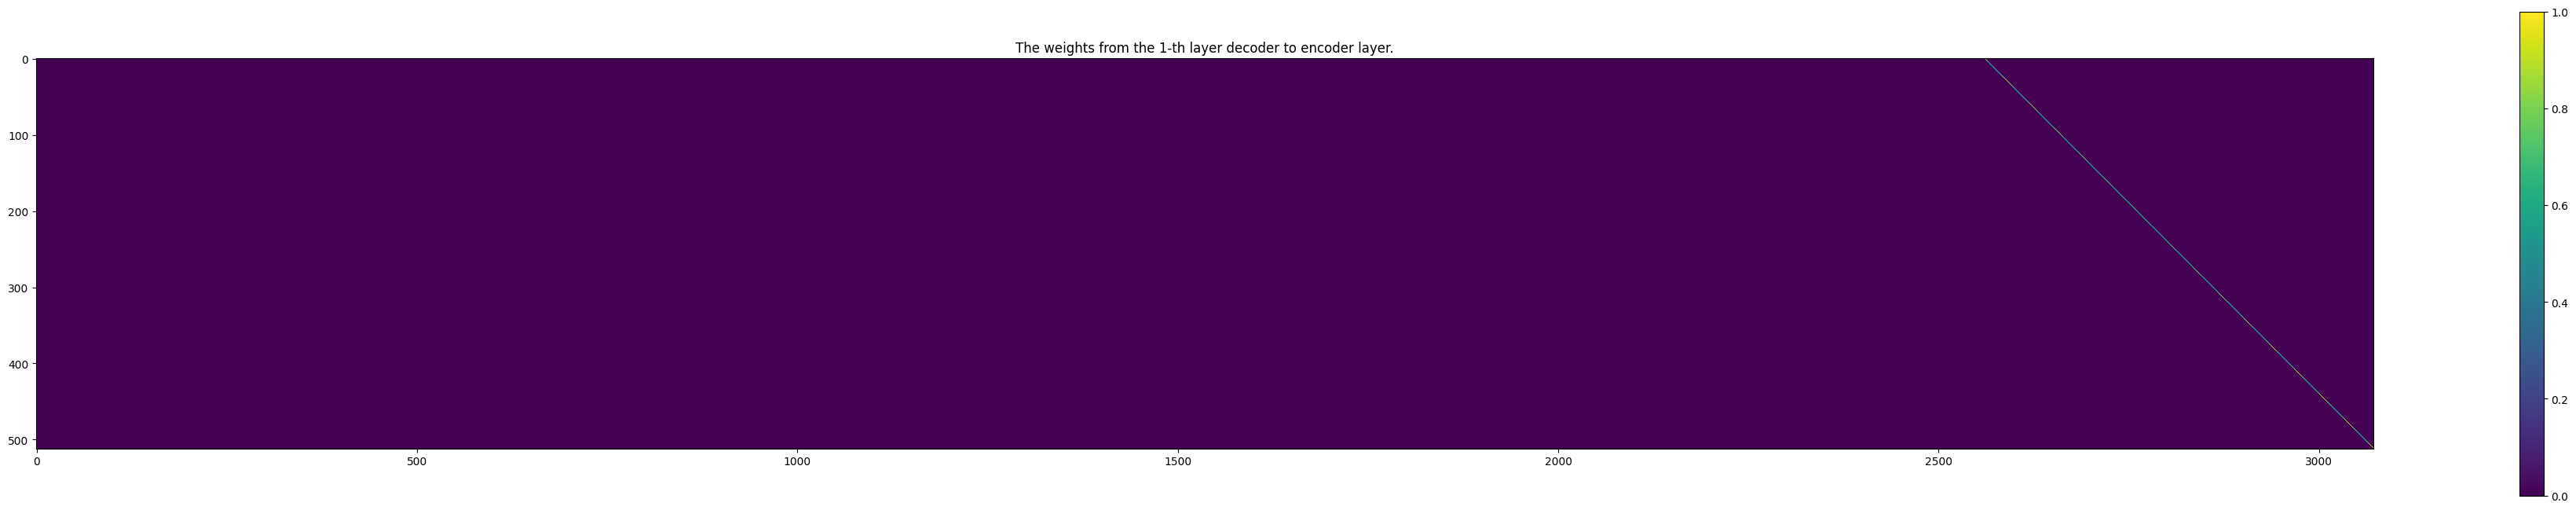

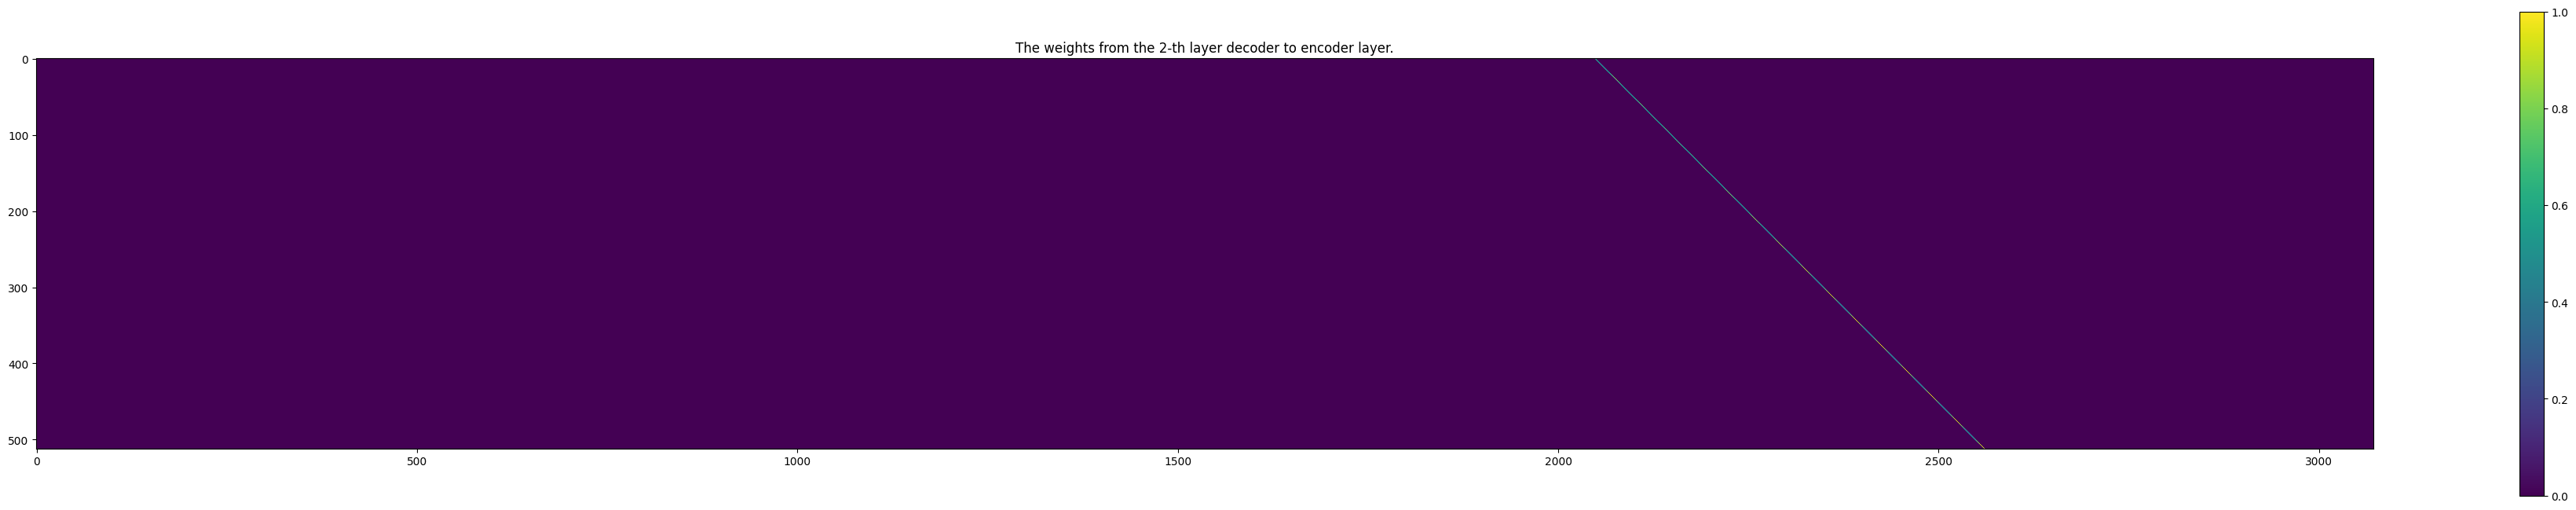

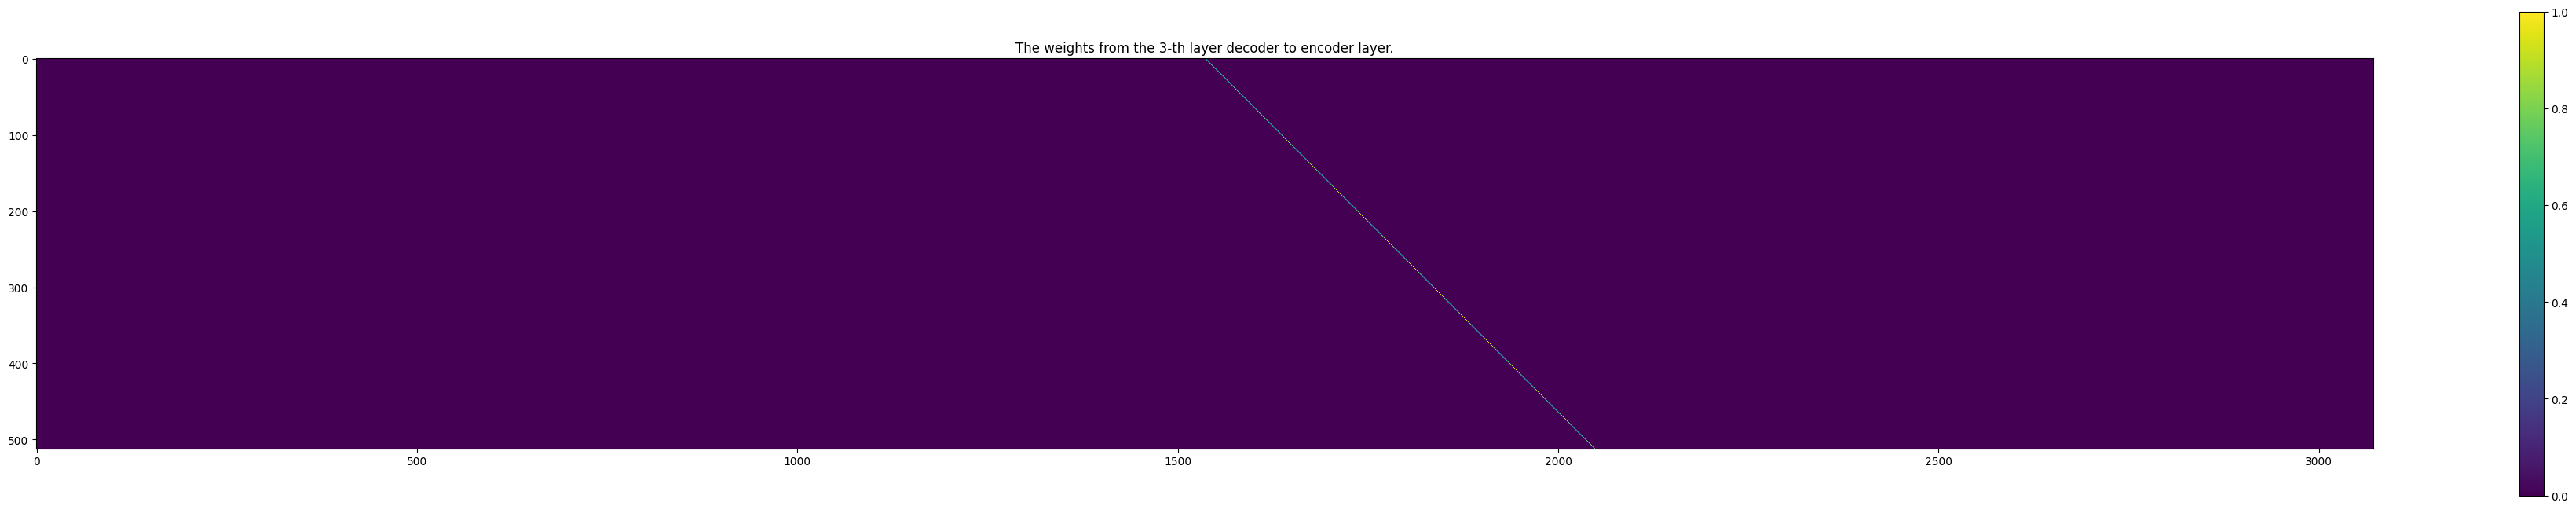

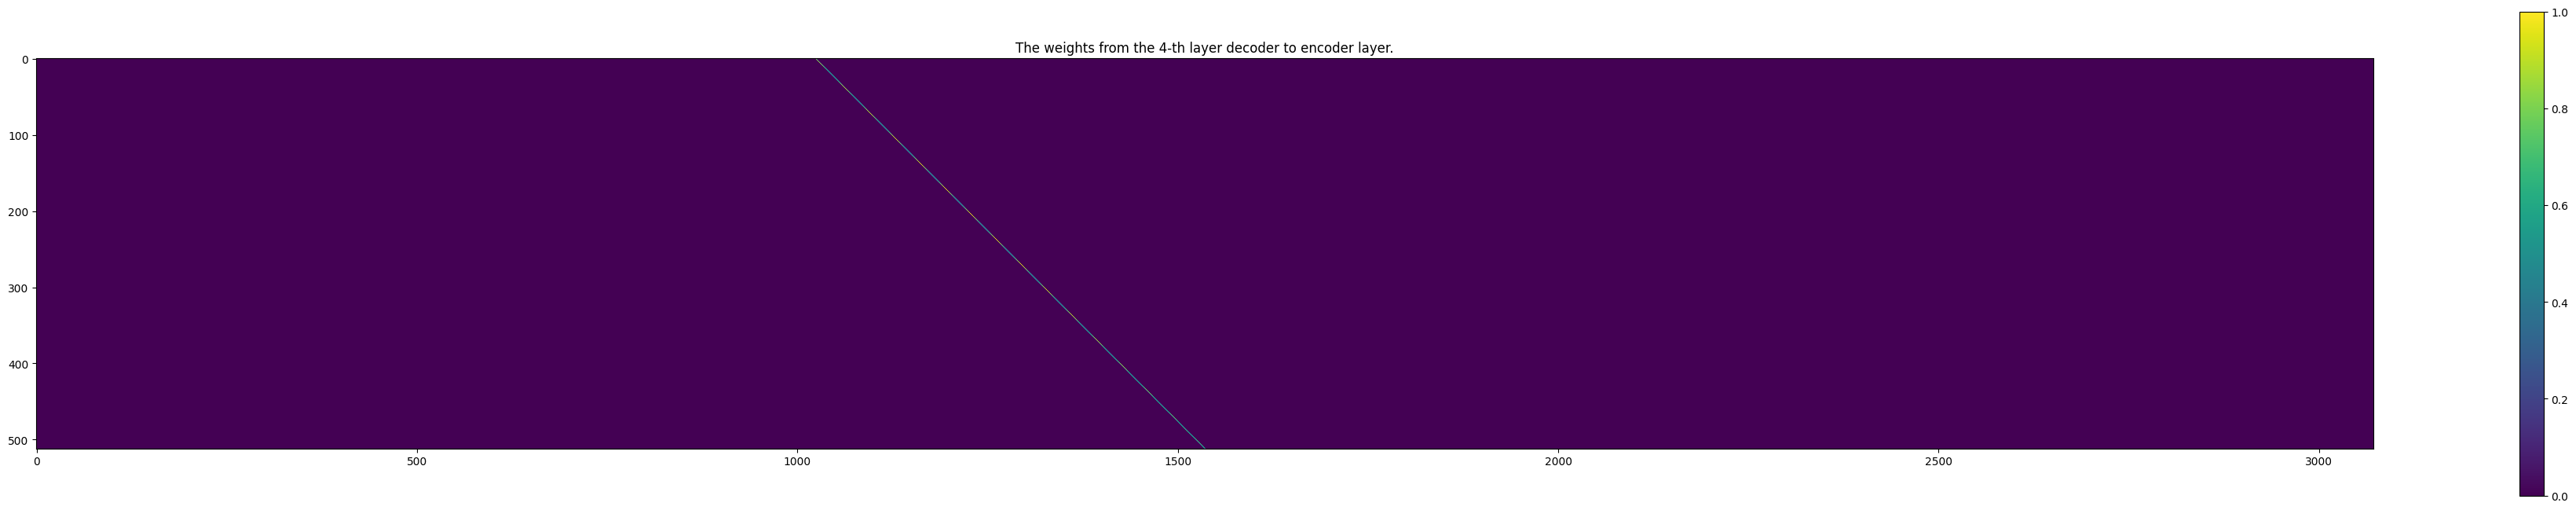

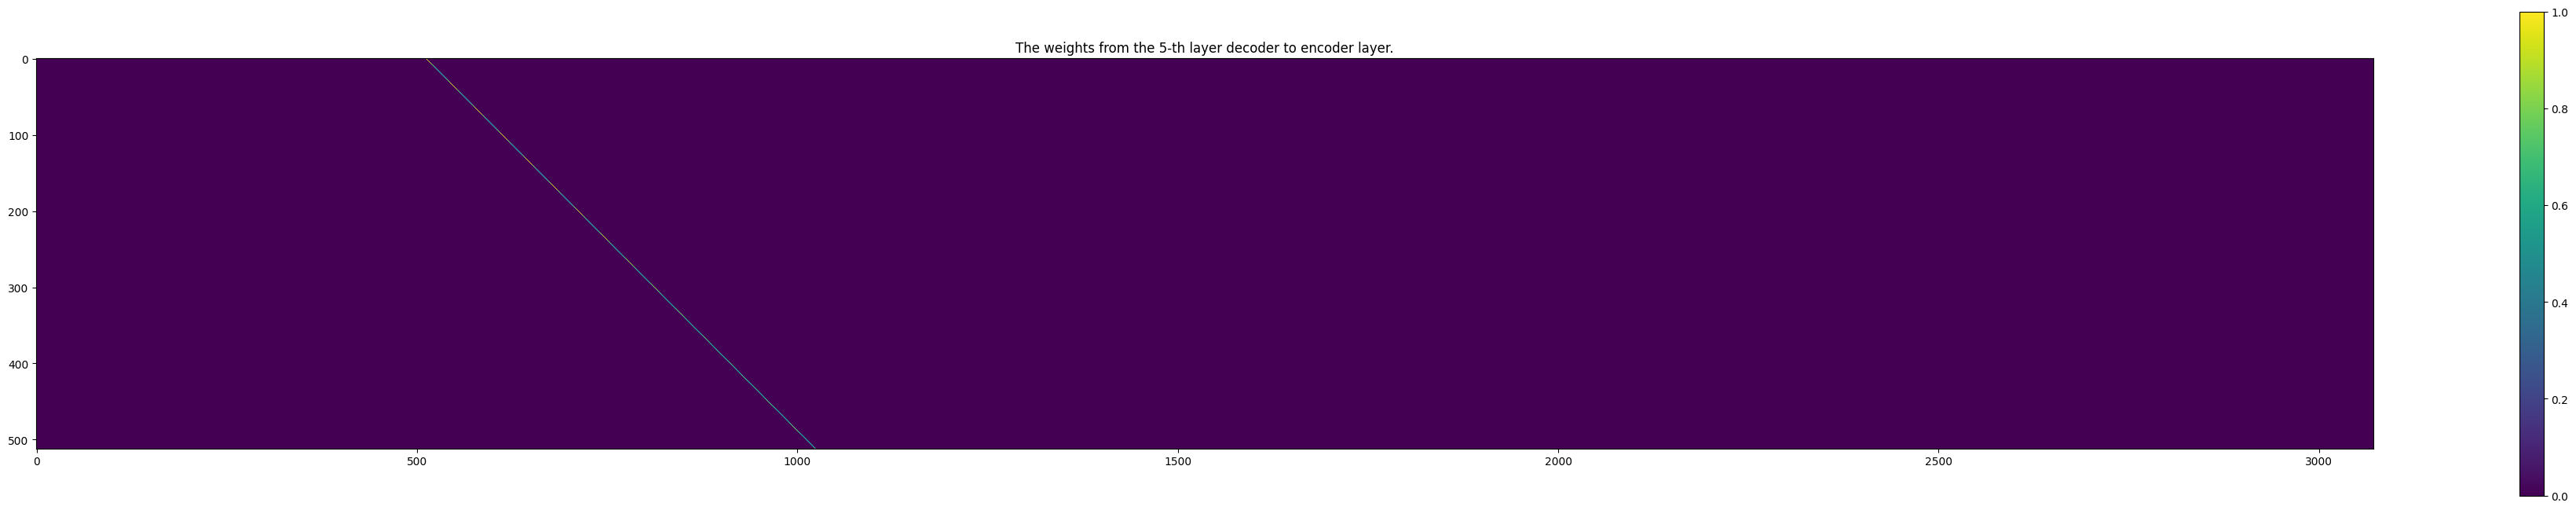

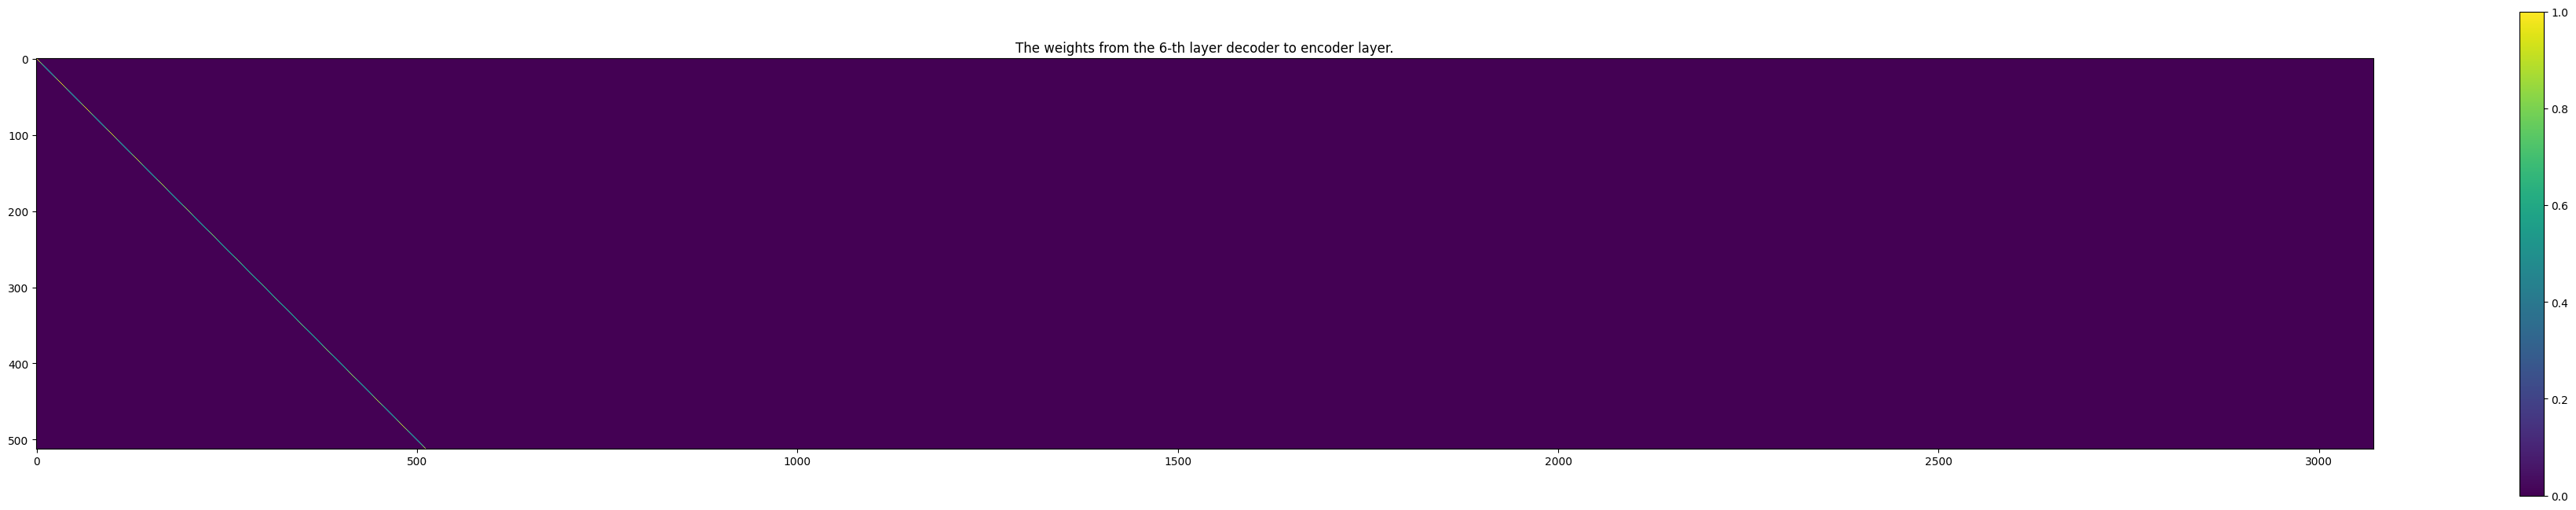

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt

for i, (name, param) in enumerate(model.model.decoder.additional_linear_layers.named_parameters()):
    tensor = model.model.decoder.additional_linear_layers[i].weight.detach().numpy()
    plt.figure(figsize=(48, 8))
    plt.imshow(tensor, cmap='viridis')  # cmap 参数用于选择颜色映射
    plt.colorbar()  # 添加一个颜色条，用于显示值与颜色的对应关系
    title = f'The weights from the {i + 1}-th layer decoder to encoder layer.'
    plt.title(title)  # 添加标题

    # 检查目标文件夹是否存在，不存在则创建它
    folder_path = f'initweight/{i + 1}-th decoder'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    plt.savefig(f'initweight/{i + 1}-th decoder.png')

In [26]:
# small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_train_dataset = tokenized_datasets["train"].shuffle().select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10))

args = Seq2SeqTrainingArguments(
    "test-translation",
    evaluation_strategy = "no",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=False,
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    # train_dataset=small_train_dataset,
    # eval_dataset=small_eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/root/miniconda3/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [27]:
trainer.train()
trainer.evaluate(output_hidden_states=True, output_attentions=True)

Step,Training Loss
500,2.490900
1000,1.938100
1500,1.796400
2000,1.719400
2500,1.664500
3000,1.634700
3500,1.620300
4000,1.562300
4500,1.563500
5000,1.544100


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

enter compute_metrics
out compute_metrics


{'eval_loss': 1.4602397680282593,
 'eval_bleu': 32.1451,
 'eval_gen_len': 26.4615,
 'eval_runtime': 113.8837,
 'eval_samples_per_second': 26.334,
 'eval_steps_per_second': 1.651,
 'epoch': 1.0}

In [28]:
trainer.evaluate(output_hidden_states=True, output_attentions=True)

enter compute_metrics
out compute_metrics


{'eval_loss': 1.4602397680282593,
 'eval_bleu': 32.1451,
 'eval_gen_len': 26.4615,
 'eval_runtime': 112.551,
 'eval_samples_per_second': 26.646,
 'eval_steps_per_second': 1.67,
 'epoch': 1.0}

In [29]:
model.save_pretrained("saved_model_directory-test3")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58100]], 'forced_eos_token_id': 0}


In [14]:
model = AutoModelForSeq2SeqLM.from_pretrained('saved_model_directory-test3', config=model_config)

Some weights of the model checkpoint at saved_model_directory-test3 were not used when initializing MarianMTModel: ['model.decoder.additional_linear_layers.0.weight', 'model.decoder.additional_linear_layers.1.weight', 'model.decoder.additional_linear_layers.2.weight', 'model.decoder.additional_linear_layers.3.weight', 'model.decoder.additional_linear_layers.4.weight', 'model.decoder.additional_linear_layers.5.weight']
- This IS expected if you are initializing MarianMTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianMTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
model

NameError: name 'model' is not defined